# The Electron Collection

Electrons are single-track particles. They are reconstructed with energy deposits in the calorimeter and an associated track. There a number of `working_points` and `isolation`s defined by the Egamma working group. We will look at accessing a few of them.


In [15]:
import matplotlib.pyplot as plt
from config import ds_zee as ds
from helpers import match_objects
import awkward as ak

The default electron we fetch is the so-called `MediumLHElectron` muon with `NonIso` isolation.

In [16]:
electrons = (ds
            .SelectMany(lambda e: e.Electrons("Electrons"))
            .Select(lambda e: e.pt() / 1000.0)
            .AsAwkwardArray('pt')
            .value())

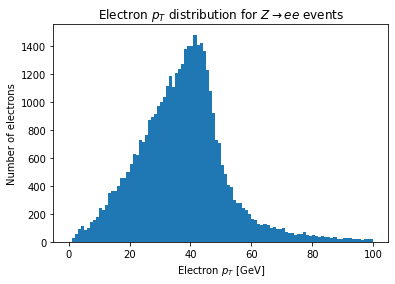

In [17]:
plt.hist(electrons.pt, bins=100, range=(0, 100))
plt.xlabel('Electron $p_T$ [GeV]')
plt.ylabel('Number of electrons')
_ = plt.title('Electron $p_T$ distribution for $Z\\rightarrow ee$ events')

## Electron Types

Electrons come in several different flavors. We can look at the different $\eta$ distributions for the electrons. Isolation is another axis we can alter, not shown here, by changing the `isolation` argument to `Electrons`.

In [18]:
electrons = (ds
             .Select(lambda e: {
                 'tight_eta': e.Electrons("Electrons", working_point='TightLHElectron').Select(lambda m: m.eta()),
                 'loose_eta': e.Electrons("Electrons", working_point='LooseLHElectron').Select(lambda m: m.eta()),
                 'medium_eta': e.Electrons("Electrons", working_point='MediumLHElectron').Select(lambda m: m.eta()),
                 })
             .AsAwkwardArray()
             .value())

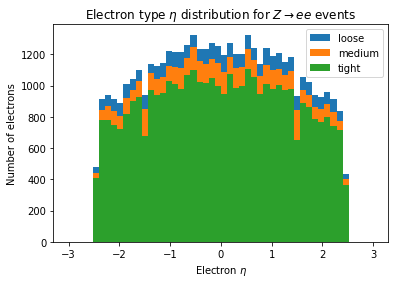

In [19]:
plt.hist(ak.flatten(electrons.loose_eta), bins=50, range=(-3, 3), label='loose')
plt.hist(ak.flatten(electrons.medium_eta), bins=50, range=(-3, 3), label='medium')
plt.hist(ak.flatten(electrons.tight_eta), bins=50, range=(-3, 3), label='tight')
plt.xlabel('Electron $\\eta$')
plt.ylabel('Number of electrons')
plt.title('Electron type $\\eta$ distribution for $Z\\rightarrow ee$ events')
_ = plt.legend()

## Calibration

By default the muons we pulled are `Medium` quality and calibrated. One can request different systematic errors using the `calibration` argument to the `Muons` method.

In [20]:
electrons = (ds
             .Select(lambda e: e.Electrons("Electrons"))
             .Select(lambda eles: {
                 'pt': eles.Select(lambda e: e.pt() / 1000.0),
                 'eta': eles.Select(lambda e: e.eta()),
                 'phi': eles.Select(lambda e: e.phi()),
             })
             .AsAwkwardArray()
             .value())

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `False` (there is very little reason one will do this normally):

In [21]:
raw_electrons = (ds
                 .Select(lambda e: e.Electrons("Electrons", calibration=None))
                 .Select(lambda eles: {
                     'pt': eles.Select(lambda j: j.pt() / 1000.0),
                     'eta': eles.Select(lambda j: j.eta()),
                     'phi': eles.Select(lambda j: j.phi()),
                 })
                 .AsAwkwardArray()
                 .value())

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [22]:
raw_electrons_matched = match_objects(electrons, raw_electrons)

Note the units along the x-axis here!! We are using **MeV** not *GeV*!

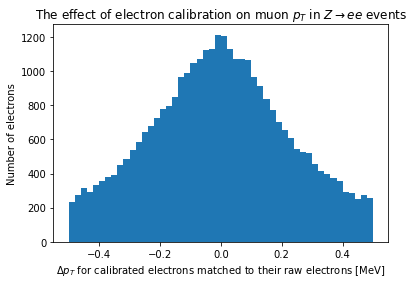

In [23]:
plt.hist(ak.flatten(electrons.pt-raw_electrons_matched.pt), bins=50, range=(-0.5, 0.5))
plt.xlabel('$\Delta p_T$ for calibrated electrons matched to their raw electrons [MeV]')
plt.ylabel('Number of electrons')
_ = plt.title('The effect of electron calibration on muon $p_T$ in $Z\\rightarrow ee$ events')

If we instead want a particular systematic error, we need only name that error to get it back. Knowing what the names of the systematic errors, however, is not something that can be programmatically determined ahead of time. See the further information section at the end of this chapter to links to the ATLAS muon calibration info twiki.

In [24]:
sys_electrons = (ds
                 .Select(lambda e: e.Electrons("Electrons", calibration="EG_RESOLUTION_ALL__1up"))
                 .Select(lambda eles: {
                      'pt': eles.Select(lambda j: j.pt() / 1000.0),
                      'eta': eles.Select(lambda j: j.eta()),
                      'phi': eles.Select(lambda j: j.phi()),
                      })
                 .AsAwkwardArray()
                 .value())

In [25]:
sys_electrons_match = match_objects(electrons, sys_electrons)

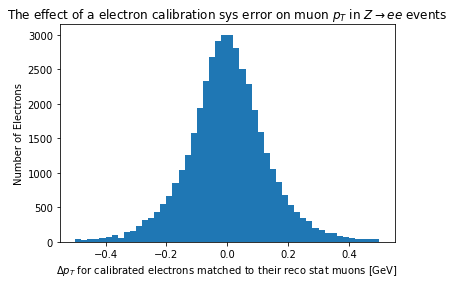

In [26]:
plt.hist(ak.flatten(electrons.pt-sys_electrons_match.pt), bins=50, range=(-0.5, 0.5))
plt.xlabel('$\Delta p_T$ for calibrated electrons matched to their reco stat muons [GeV]')
plt.ylabel('Number of Electrons')
_ = plt.title('The effect of a electron calibration sys error on muon $p_T$ in $Z\\rightarrow ee$ events')

## The Data Model

The data model when this documentation was last built is.

In [27]:
from func_adl_servicex_xaodr21.xAOD.electron_v1 import Electron_v1
help(Electron_v1)

Help on class Electron_v1 in module func_adl_servicex_xaodr21.xAOD.electron_v1:

class Electron_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  OQ(self) -> 'int'
 |      A method
 |  
 |  ambiguousObject(self) -> 'func_adl_servicex_xaodr21.xAOD.egamma_v1.Egamma_v1'
 |      A method
 |  
 |  caloCluster(self, index: 'int') -> 'func_adl_servicex_xaodr21.xAOD.calocluster_v1.CaloCluster_v1'
 |      A method
 |  
 |  caloClusterLink(self, index: 'int') -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_calocluster_v1__.ElementLink_DataVector_xAOD_CaloCluster_v1__'
 |      A method
 |  
 |  caloClusterLinks(self) -> 'func_adl_servicex_xaodr21.vector_elementlink_datavector_xaod_calocluster_v1___.vector_ElementLink_DataVector_xAOD_CaloCluster_v1___'
 |      A method
 |  
 |  charge(self) -> 'float'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method

## Further Information

* The [`xAOD::Electron_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODEgamma/xAODEgamma/versions/Electron_v1.h) with all the inline documentation.
* The [Electron Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/LatestRecommendationsElectronIDRun2) on the ATLAS TWiki
* The [Electron Working Points Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/EGammaIdentificationRun2) on the ATLAS Twiki